# 프로젝트: CutMix 또는 Mixup 비교실험 하기
---
## 1. Augmentation을 적용한 데이터셋 만들기
---
데이터셋에 CutMix 또는 Mixup augmentation을 적용  

### 데이터 준비

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [2]:
print('train:', len(ds_train))
print('test:', len(ds_test))

train: 12000
test: 8580


#### 전처리 함수

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# --------------------------------------------------------
# augmentation
# --------------------------------------------------------
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# --------------------------------------------------------
# Cutmix
# --------------------------------------------------------
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, img_size=224, num_classes=120):
    image_size_x = img_size
    image_size_y = img_size
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels
# --------------------------------------------------------
# Mixup
# --------------------------------------------------------
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# --------------------------------------------------------
# 데이터 가공 함수
# --------------------------------------------------------
def onehot(image, label, num_classes=120):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    # CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에 배치 단위로 데이터셋을 정렬 후 CutMix 적용
    ds = ds.batch(batch_size)
    if not is_test and (with_cutmix or with_mixup):
        if with_cutmix:            
            ds = ds.map(
                cutmix,
                num_parallel_calls=2
            )
            
        if with_mixup:            
            ds = ds.map(
                mixup,
                num_parallel_calls=2
            )    
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
            
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train) # No Augmentation
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug = True) # 기본 Augmentation
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug = True, with_cutmix=True) # 기본 Augmentation + cutmix
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug = True, with_mixup=True) # 기본 Augmentation + mixup

ds_val = apply_normalize_on_dataset(ds_test, is_test=True)

---
## 2. 모델 만들기
---
ResNet-50 사용

In [16]:
def get_resnet50(num_classes=120):
    return keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224,224,3),
            pooling='avg',
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

---
## 3. 모델 훈련하기
---
**손실함수 categorical_crossentropy** 사용  
cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문

### 모델 훈련 함수

In [22]:
def compile_and_fit(train_data, val_data, epochs=5, model=None):
    if model is None:
        model = get_resnet50()
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

    return model, model.fit(
        train_data, 
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=epochs,
        validation_data=val_data,
        verbose=1,
        use_multiprocessing=True,
    )

#### No Augmentation 모델 훈련

In [23]:
resnet50_no_aug, history_no_aug = compile_and_fit(ds_train_no_aug, ds_val)

Epoch 1/5
750/750 [==============================] - 159s 203ms/step - loss: 2.2180 - accuracy: 0.4459 - val_loss: 3.0761 - val_accuracy: 0.2530
Epoch 2/5
750/750 [==============================] - 151s 202ms/step - loss: 0.7124 - accuracy: 0.8042 - val_loss: 1.1042 - val_accuracy: 0.6695
Epoch 3/5
750/750 [==============================] - 152s 202ms/step - loss: 0.2250 - accuracy: 0.9546 - val_loss: 0.9490 - val_accuracy: 0.7177
Epoch 4/5
750/750 [==============================] - 151s 202ms/step - loss: 0.0662 - accuracy: 0.9949 - val_loss: 0.9169 - val_accuracy: 0.7333
Epoch 5/5
750/750 [==============================] - 151s 202ms/step - loss: 0.0283 - accuracy: 0.9987 - val_loss: 0.9137 - val_accuracy: 0.7390


#### 기본 Augmentation 모델 훈련

In [24]:
resnet50_aug, history_aug = compile_and_fit(ds_train_aug, ds_val)

Epoch 1/5
750/750 [==============================] - 159s 203ms/step - loss: 2.8391 - accuracy: 0.3067 - val_loss: 3.1389 - val_accuracy: 0.2343
Epoch 2/5
750/750 [==============================] - 151s 202ms/step - loss: 1.5626 - accuracy: 0.5578 - val_loss: 1.4071 - val_accuracy: 0.5948
Epoch 3/5
750/750 [==============================] - 151s 202ms/step - loss: 1.1096 - accuracy: 0.6759 - val_loss: 1.6874 - val_accuracy: 0.5374
Epoch 4/5
750/750 [==============================] - 151s 202ms/step - loss: 0.7909 - accuracy: 0.7723 - val_loss: 1.4795 - val_accuracy: 0.5914
Epoch 5/5
750/750 [==============================] - 151s 202ms/step - loss: 0.5693 - accuracy: 0.8402 - val_loss: 1.3542 - val_accuracy: 0.6284


#### 기본 + CutMix Augmentation 모델 훈련

In [28]:
resnet50_aug_cutmix, history_aug_cutmix = compile_and_fit(ds_train_aug_cutmix, ds_val)

Epoch 1/5
750/750 [==============================] - 163s 206ms/step - loss: 4.1713 - accuracy: 0.1258 - val_loss: 3.5580 - val_accuracy: 0.1802
Epoch 2/5
750/750 [==============================] - 171s 228ms/step - loss: 3.3901 - accuracy: 0.2941 - val_loss: 2.0045 - val_accuracy: 0.4553
Epoch 3/5
750/750 [==============================] - 155s 207ms/step - loss: 3.0694 - accuracy: 0.3882 - val_loss: 1.6116 - val_accuracy: 0.5563
Epoch 4/5
750/750 [==============================] - 154s 206ms/step - loss: 2.9034 - accuracy: 0.4402 - val_loss: 1.4302 - val_accuracy: 0.5984
Epoch 5/5
750/750 [==============================] - 158s 211ms/step - loss: 2.7907 - accuracy: 0.4742 - val_loss: 1.3829 - val_accuracy: 0.6109


#### 기본 + MixUp Augmentation 모델 훈련

In [29]:
resnet50_aug_mixup, history_aug_mixup = compile_and_fit(ds_train_aug_mixup, ds_val)

Epoch 1/5
750/750 [==============================] - 162s 205ms/step - loss: 4.0999 - accuracy: 0.1458 - val_loss: 4.3591 - val_accuracy: 0.0857
Epoch 2/5
750/750 [==============================] - 153s 204ms/step - loss: 3.3213 - accuracy: 0.3266 - val_loss: 1.9204 - val_accuracy: 0.4756
Epoch 3/5
750/750 [==============================] - 153s 204ms/step - loss: 3.0714 - accuracy: 0.4036 - val_loss: 1.8556 - val_accuracy: 0.4958
Epoch 4/5
750/750 [==============================] - 153s 204ms/step - loss: 2.9162 - accuracy: 0.4565 - val_loss: 1.7438 - val_accuracy: 0.5251
Epoch 5/5
750/750 [==============================] - 153s 204ms/step - loss: 2.7910 - accuracy: 0.5019 - val_loss: 1.5541 - val_accuracy: 0.5788


---
## 4. 훈련 과정 시각화
---

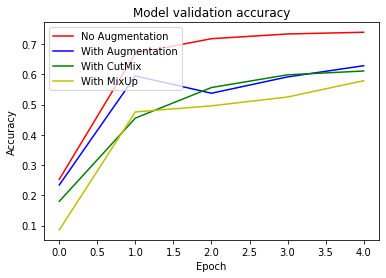

In [31]:
plt.plot(history_no_aug.history['val_accuracy'], 'r')
plt.plot(history_aug.history['val_accuracy'], 'b')
plt.plot(history_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_aug_mixup.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()

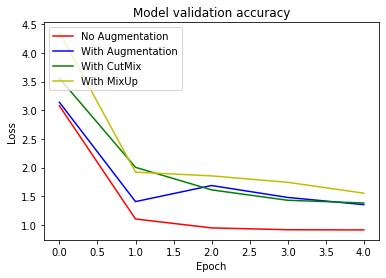

In [32]:
plt.plot(history_no_aug.history['val_loss'], 'r')
plt.plot(history_aug.history['val_loss'], 'b')
plt.plot(history_aug_cutmix.history['val_loss'], 'g')
plt.plot(history_aug_mixup.history['val_loss'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With MixUp'], loc='upper left')
plt.show()